# Turn truth tables into degenerate graphs and visualize those graphs

### Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import networkx as nx

### Truth Tables / Gates

In [2]:
sns.set(
    context="talk",
    font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)

### $A \land B$ gate

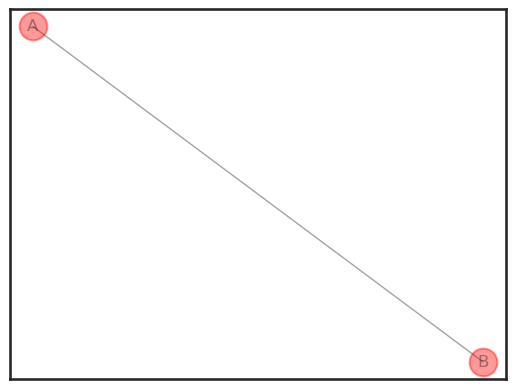

In [3]:
gate_states = [
    # A B
    [0, 0],
    [1, 0],
    [0, 1],
    [1, 1],
]

truth_vector = np.array([0, 0, 0, 1])


and_edges = [("A", "B"), ("B", "A")]
AND_gate = nx.Graph()
AND_gate.add_edges_from(and_edges)

options = {"node_color": "red", "node_size": 400, "alpha": 0.4}
nx.draw_networkx(AND_gate, with_labels=True, **options)
plt.show()

Aside: Below three-component gate graphs are only one of many possible degenerate graph solutions, work in progress. weights can be added as edge components to list as well

### $(A \land B) \lor C$ gate

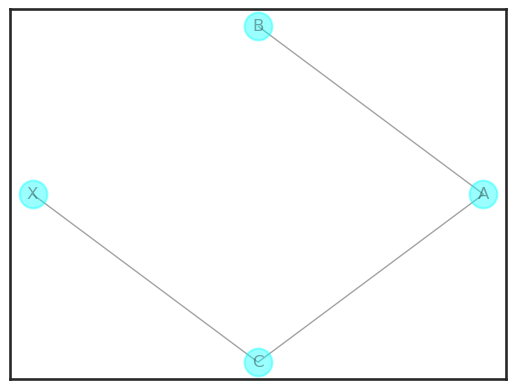

In [4]:
gate_states = [
    # A B C
    [0, 0, 0],
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [1, 1, 0],
    [1, 0, 1],
    [0, 1, 1],
    [1, 1, 1],
]

truth_vector = np.array([0, 0, 0, 1, 1, 1, 1, 1])

ANDOR_gate = nx.Graph()
ANDOR_gate.add_edges_from(and_edges + [("X", "C"), ("C", "X"), ("A", "C"), ("C", "A")])

options = {"node_color": "cyan", "node_size": 400, "alpha": 0.4}
nx.draw_networkx(
    ANDOR_gate, nx.circular_layout(ANDOR_gate), with_labels=True, **options
)
plt.show()

### all x all matrix
column 8 is wrong

In [5]:
allxall = np.load("allxall.npy")
# fix column 8 for now
allxall[:,7] = (allxall[:,7] * 0.10)
# add axis labels
xlabels = ["BW3_A_sm", "BW3_B_sm","BW5_A_sm","BW5_B_sm","IL8_A_sm","IL8_B_sm","IL9_A_sm","IL9_B_sm","IL14_A_sm","IL14_B_sm"]
ylabels = ["BW3_B_lg", "BW3_A_lg","BW5_B_lg","BW5_A_lg","IL8_B_lg","IL8_A_lg","IL9_B_lg","IL9_A_lg","IL14_B_lg","IL14_A_lg"]

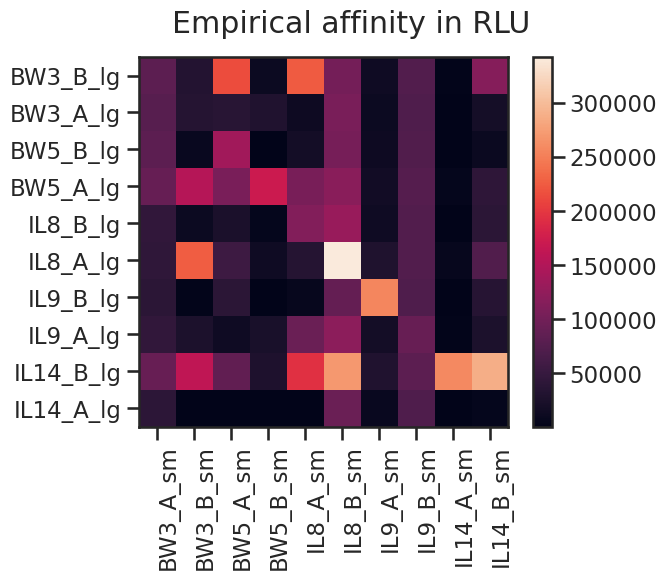

In [6]:
def plot_mat(matrix, xlabels, ylabels, title):
    fig, ax = plt.subplots()
    # We want to show all ticks...
    ax.set_xticks(np.arange(matrix.shape[0]))
    ax.set_yticks(np.arange(matrix.shape[1]))
    # ... and label them with the respective list entries
    ax.set_xticklabels(xlabels)
    ax.set_yticklabels(ylabels)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")
    mat = ax.imshow(matrix)
    fig.suptitle(title)
    fig.colorbar(mappable=mat)
    plt.show()
    return


plot_mat(allxall, xlabels, ylabels, "Empirical affinity in RLU")

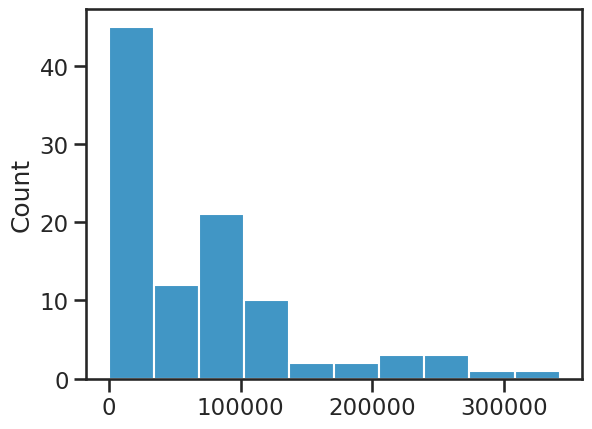

In [7]:
# get distribution of data
flat = allxall.flatten() #.reshape([1,100])
_ = sns.histplot(flat, bins="auto")
plt.show()

# Probably can threshold around 3.3e4

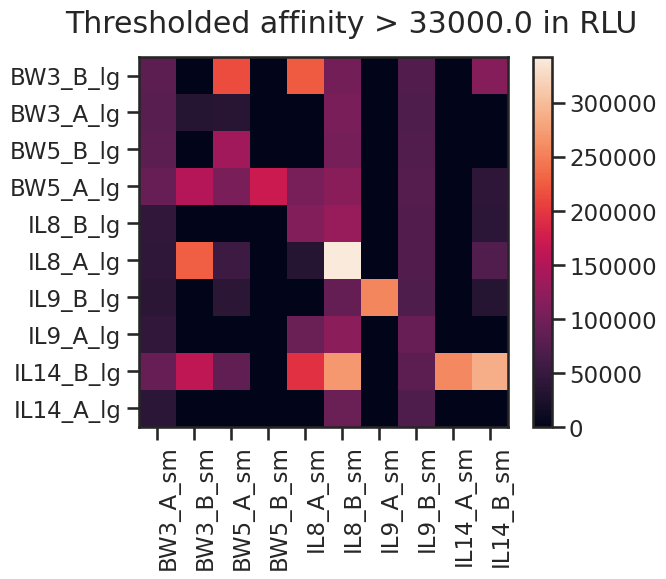

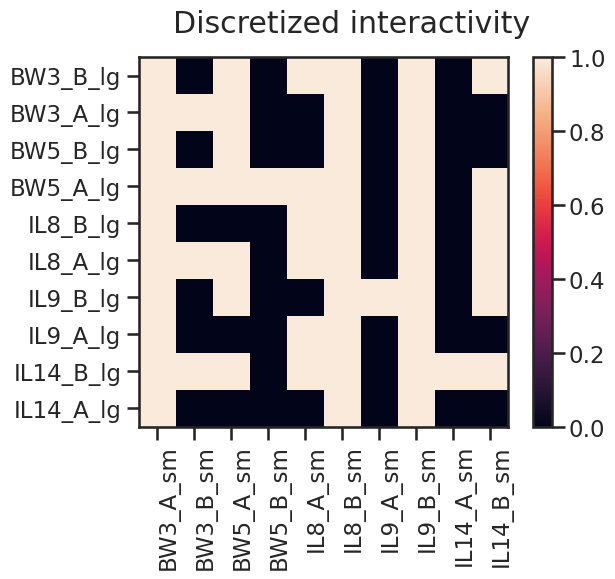

In [8]:
# if less than 3.3e4, 0
cutoff = 3.3e4
thresholded = allxall.copy()
thresholded[thresholded < cutoff] = 0
plot_mat(thresholded, xlabels, ylabels, f"Thresholded affinity > {cutoff} in RLU")

# discretize, if > 0, 1
discrete = thresholded.copy()
discrete[discrete > 0] = 1
plot_mat(discrete, xlabels, ylabels, f"Discretized interactivity")

### Try to build a graph by looping over the discretized matrix

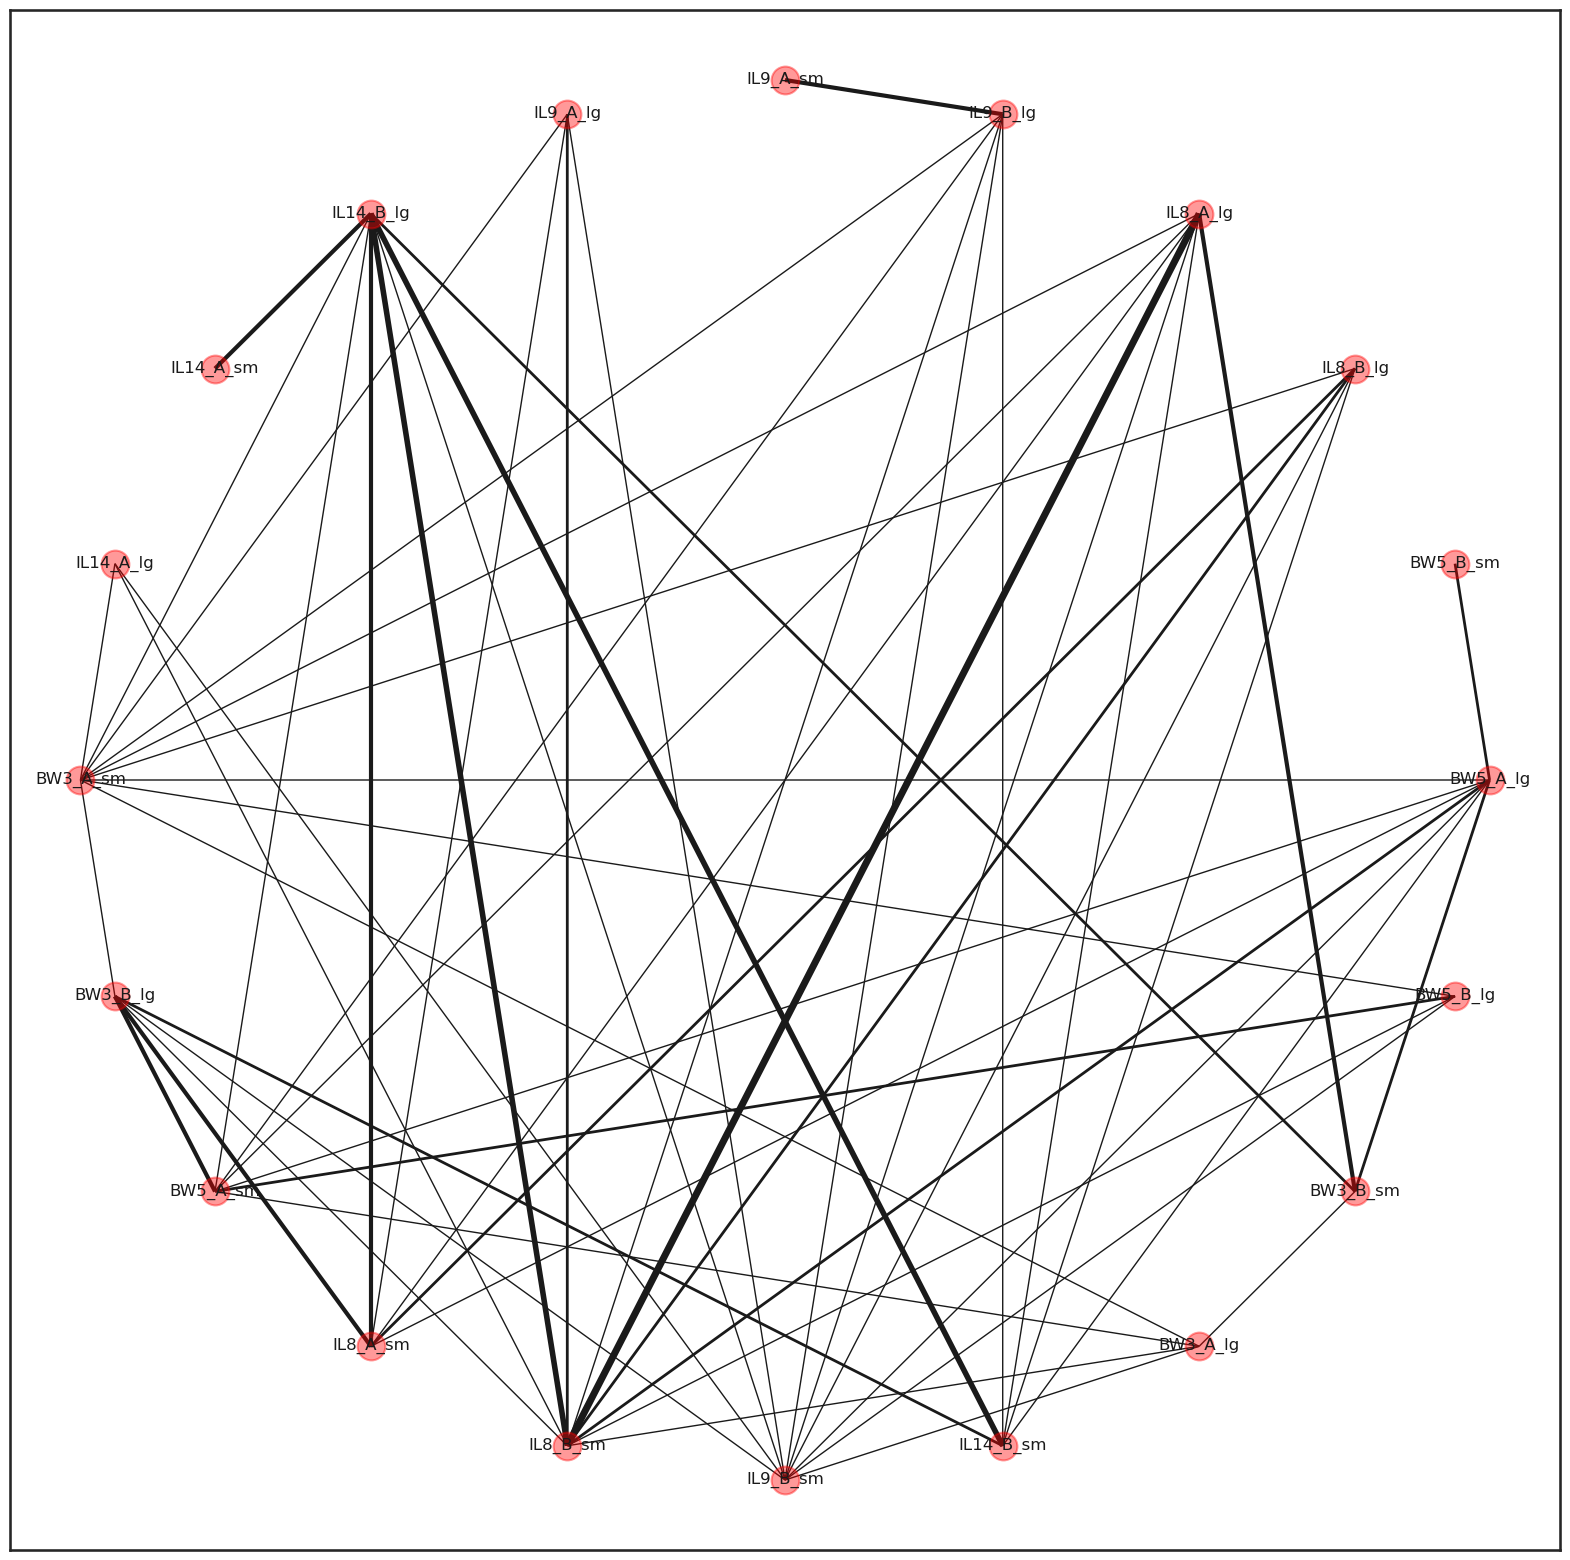

In [9]:
plt.close()
G = nx.Graph()

edges = []
for row, ylabel in enumerate(ylabels):
    for col, xlabel in enumerate(xlabels):
        if bool(discrete[row,col]):
#             edges.append((ylabel, xlabel))
            G.add_node(xlabel, chain=xlabel.split("_")[1], bit=xlabel.split("_")[-1])
            G.add_node(ylabel, chain=ylabel.split("_")[1], bit=ylabel.split("_")[-1])
            edges.append((xlabel, ylabel, {"weight": thresholded[row,col]}))
        else:
            pass


G.add_edges_from(edges)
pos = nx.circular_layout(G)
weights = nx.get_edge_attributes(G, "weight")

# bin and discretize weights for plotting
bins = np.linspace(min(weights.values()), max(weights.values()), 5)
weights = dict(zip(weights.keys(), np.digitize(list(weights.values()), bins=bins)))
# weights = {key: np.log10(value) for key, value in weights.items()}

nodelist = G.nodes()

options = {"node_color": "red", "node_size": 400, "alpha": 0.4}
plt.figure(figsize=(20,20))

# nx.draw(G, pos=pos, with_labels=True, **options)
# nx.draw_networkx_edges(labels, pos=pos, edge_labels=weights)

pos = nx.shell_layout(G)
nx.draw_networkx_nodes(G,pos,
                       nodelist=nodelist,
#                        node_size=1500,
                       **options,
#                        node_color='black',
#                        alpha=0.7
                      )
nx.draw_networkx_edges(G,pos,
                       edgelist = weights.keys(),
                       width=list(weights.values()),
#                        edge_color='lightblue',
#                        alpha=0.6
                      )
nx.draw_networkx_labels(G, pos=pos,
                        labels=dict(zip(nodelist,nodelist)),
#                         font_color='white'
                       )
plt.show()
        

### What a mess. Still, it seems correct... 

In [10]:
nx.get_node_attributes(G, "bit")

{'BW3_A_sm': 'sm',
 'BW3_B_lg': 'lg',
 'BW5_A_sm': 'sm',
 'IL8_A_sm': 'sm',
 'IL8_B_sm': 'sm',
 'IL9_B_sm': 'sm',
 'IL14_B_sm': 'sm',
 'BW3_A_lg': 'lg',
 'BW3_B_sm': 'sm',
 'BW5_B_lg': 'lg',
 'BW5_A_lg': 'lg',
 'BW5_B_sm': 'sm',
 'IL8_B_lg': 'lg',
 'IL8_A_lg': 'lg',
 'IL9_B_lg': 'lg',
 'IL9_A_sm': 'sm',
 'IL9_A_lg': 'lg',
 'IL14_B_lg': 'lg',
 'IL14_A_sm': 'sm',
 'IL14_A_lg': 'lg'}

In [11]:
nx.get_node_attributes(G, "chain")

{'BW3_A_sm': 'A',
 'BW3_B_lg': 'B',
 'BW5_A_sm': 'A',
 'IL8_A_sm': 'A',
 'IL8_B_sm': 'B',
 'IL9_B_sm': 'B',
 'IL14_B_sm': 'B',
 'BW3_A_lg': 'A',
 'BW3_B_sm': 'B',
 'BW5_B_lg': 'B',
 'BW5_A_lg': 'A',
 'BW5_B_sm': 'B',
 'IL8_B_lg': 'B',
 'IL8_A_lg': 'A',
 'IL9_B_lg': 'B',
 'IL9_A_sm': 'A',
 'IL9_A_lg': 'A',
 'IL14_B_lg': 'B',
 'IL14_A_sm': 'A',
 'IL14_A_lg': 'A'}